Importamos librerias

In [56]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy  as np  
from sklearn.feature_selection import f_regression, mutual_info_regression
import math
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate

import cv2
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Leemos la base de datos y nos quedamos con madrid

In [3]:
dataframe = pd.read_csv("drive/MyDrive/airbnb-listings.csv", sep=';')

dataframe = dataframe[dataframe['City']=='Madrid']

dataframe.head()


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,Transit,Access,Interaction,House Rules,Thumbnail Url,Medium Url,Picture Url,XL Picture Url,Host ID,Host URL,Host Name,Host Since,Host Location,Host About,Host Response Time,Host Response Rate,Host Acceptance Rate,Host Thumbnail Url,Host Picture Url,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Host Verifications,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,...,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Square Feet,Price,Weekly Price,Monthly Price,Security Deposit,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Has Availability,Availability 30,Availability 60,Availability 90,Availability 365,Calendar last Scraped,Number of Reviews,First Review,Last Review,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,15141125,https://www.airbnb.com/rooms/15141125,20170407214119,2017-04-08,Panoramic charming studio!,"Charming bright and cosy studio in ""El Rastro""...",It's a bright and cosy studio located in the h...,"Charming bright and cosy studio in ""El Rastro""...",none,The studio is located in the remarkable neighb...,NaN,The closest metro is La latina which will take...,The full studio will be entirely to the guests...,I am delighted to preform the check in at the ...,NaN,https://a0.muscache.com/im/pictures/d1a2212d-c...,https://a0.muscache.com/im/pictures/d1a2212d-c...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/d1a2212d-c...,96019257,https://www.airbnb.com/users/show/96019257,Marina,2016-09-20,"Madrid, Community of Madrid, Spain",I have a serious addiction for traveling :0l! ...,within an hour,100.0,NaN,https://a0.muscache.com/im/pictures/fffbb86e-5...,https://a0.muscache.com/im/pictures/fffbb86e-5...,NaN,2.0,2.0,"email,phone,facebook,reviews,jumio,government_id","Madrid, Comunidad de Madrid 28005, Spain",NaN,Embajadores,Centro,Madrid,Comunidad de Madrid,...,2,1.0,0.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Pets all...",NaN,50.0,NaN,NaN,100.0,20.0,2,15,2,1125,today,NaN,13,24,42,66,2017-04-07,30,2016-10-15,2017-03-31,96.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,moderate,2.0,5.11,"40.4074526848,-3.70799547544","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,9470166,https://www.airbnb.com/rooms/9470166,20170407214119,2017-04-08,Comfortable penthouse in the center,"In the center, recently remodeled, comfortable...",Quiet and comfortable space where you can rela...,"In the center, recently remodeled, comfortable...",none,It belongs to the district center of Madrid wh...,A la misma distancia en tiempo podrás acceder ...,"The nearest Metro station is Tirso de Molina ,...","You will be alone, while you are in my flat an...",If you have any questions while you are in the...,Check ins after 21h to 22h have an extra cost ...,https://a0.muscache.com/im/pictures/3eb59287-8...,https://a0.muscache.com/im/pictures/3eb59287-8...,https://public.opendatasoft.com/api/v2/catalog...,https://a0.muscache.com/im/pictures/3eb59287-8...,9885245,https://www.airbnb.com/users/show/9885245,Jorge,2013-11-08,"Madrid, Community of Madrid, Spain",NaN,within an hour,100.0,NaN,https://a0.muscache.com/im/users/9885245/profi...,https://a0.muscache.com/im/users/9885245/profi...,Hortaleza,13.0,13.0,"email,phone,reviews,jumio","Madrid, Comunidad de Madrid 28012, Spain",NaN,Embajadores,Centro,Madrid,Comunidad de Madrid,...,4,1.0,1.0,2.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",NaN,50.0,NaN,NaN,250.0,15.0,2,25,1,1125,3 days ago,NaN,15,42,72,347,2017-04-07,97,2015-12-01,2017-04-04,81.0,8.0,8.0,9.0,9.0,9.0,8.0,NaN,NaN,strict,13.0,5.88,"40.40831556

Arreglar los códigos postales debido a que varios de ellos se han introducido erróneamenrte en el dataset y es preferible solucionarlo antes de hacer nada


In [10]:
dataframe['Zipcode'][dataframe['Zipcode'] == ""] = math.nan
dataframe['Zipcode'][dataframe['Zipcode'] == "-"] = math.nan
dataframe['Zipcode'][dataframe['Zipcode'] == '28'] = math.nan

dataframe['Zipcode'][dataframe['Zipcode'] == 'Madrid 28004'] = '28004'

dataframe['Zipcode'][dataframe['Zipcode'] == '28002\n28002'] = '28002'
dataframe['Zipcode'][dataframe['Zipcode'] == '28051\n28051'] = '28051'

dataframe['Zipcode'][dataframe['Zipcode'] == '280013'] = '28013'
dataframe['Zipcode'][dataframe['Zipcode'] == '2015'] = '28015'
dataframe['Zipcode'][dataframe['Zipcode'] == '2815'] = '28015'
dataframe['Zipcode'][dataframe['Zipcode'] == '2805'] = '28005'
dataframe['Zipcode'][dataframe['Zipcode'] == '2804'] = '28004'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7

Vamos a ver si hay alguna variable que nos interesa eliminar desde el principio por su tipo y que no nos aportan información


In [11]:
tipos = dataframe.dtypes
print(tipos)

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
                                   ...   
Cancellation Policy                object
Calculated host listings count    float64
Reviews per Month                 float64
Geolocation                        object
Features                           object
Length: 89, dtype: object


De este modo se ha decidido eliminar todas las variables en las que se describe el airbnb a través de frases, las url, los ID que no aportan datos, los datos de localización de ciudad y país.. debido a que ya se ha preseleccionado la ciudad de Madrid y no tendría sentido emplear estos campos, los de precios ya que no tiene sentido emplearlos para predecirlo, etc.


In [12]:
dataframe = dataframe.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview', 'Notes', 'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location', 'Host About', 'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url', 'Host Total Listings Count', 'Host Verifications', 'Street', 'Host Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City', 'State', 'Market', 'Smart Location', 'Country Code', 'Country', 'Weekly Price', 'Monthly Price', 'Calendar Updated', 'Has Availability', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Calendar last Scraped', 'First Review', 'Last Review', 'License', 'Jurisdiction Names', 'Calculated host listings count', 'Geolocation', 'Features'], axis=1)


Dividimos en train y test


In [13]:
dataframe_train, dataframe_test = train_test_split(dataframe, test_size = 0.3, shuffle = False, random_state = 0)


Codificamos las variables de tipo string

In [14]:
dataframe_train['Neighbourhood'].fillna('Other', inplace=True)
le1 = preprocessing.LabelEncoder()
le1.fit(dataframe_train['Neighbourhood'])
dataframe_train['Neighbourhood'] = le1.transform(dataframe_train['Neighbourhood'])

dataframe_train['Zipcode'].fillna(dataframe_train['Zipcode'].mode()[0], inplace=True)
dataframe_train['Zipcode'] = dataframe_train['Zipcode'].astype(int)

le2 = preprocessing.LabelEncoder()
le2.fit(dataframe_train['Property Type'])
dataframe_train['Property Type'] = le2.transform(dataframe_train['Property Type'])

le3 = preprocessing.LabelEncoder()
le3.fit(dataframe_train['Room Type'])
dataframe_train['Room Type'] = le3.transform(dataframe_train['Room Type'])

le4 = preprocessing.LabelEncoder()
le4.fit(dataframe_train['Bed Type'])
dataframe_train['Bed Type'] = le4.transform(dataframe_train['Bed Type'])

dataframe_train['Amenities'].fillna('', inplace=True)
dataframe_train['Amenities'] = dataframe_train['Amenities'].apply(lambda x: len(x.split(',')))

le5 = preprocessing.LabelEncoder()
le5.fit(dataframe_train['Cancellation Policy'])
dataframe_train['Cancellation Policy'] = le5.transform(dataframe_train['Cancellation Policy'])


Vemos el número de nans por si nos interesa quitarnos más variables o rellenar

In [15]:
dataframe_train.isna().sum() 

Host Listings Count               1
Neighbourhood                     0
Zipcode                           0
Latitude                          0
Longitude                         0
Property Type                     0
Room Type                         0
Accommodates                      0
Bathrooms                        32
Bedrooms                         20
Beds                             35
Bed Type                          0
Amenities                         0
Square Feet                    8890
Price                             8
Security Deposit               5300
Cleaning Fee                   3761
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Number of Reviews                 0
Review Scores Rating           1986
Review Scores Accuracy         2000
Review Scores Cleanliness      1996
Review Scores Checkin          2009
Review Scores Communication    1996
Review Scores Location      

In [16]:
dataframe_train['Host Listings Count'].fillna(dataframe_train['Host Listings Count'].mode()[0], inplace=True)
dataframe_train['Bathrooms'].fillna(dataframe_train['Bathrooms'].mode()[0], inplace=True)
dataframe_train['Bedrooms'].fillna(dataframe_train['Bedrooms'].mode()[0], inplace=True)
dataframe_train['Beds'].fillna(dataframe_train['Beds'].mode()[0], inplace=True)
dataframe_train = dataframe_train.drop(['Square Feet'], axis=1) # Porcentaje muy alto de valores nan no nos interesa
dataframe_train['Price'].fillna(dataframe_train['Price'].mode()[0], inplace=True)
dataframe_train = dataframe_train.drop(['Security Deposit'], axis=1)
dataframe_train['Cleaning Fee'].fillna(0, inplace=True) # Porcentaje muy alto de valores nan no nos interesa
dataframe_train['Review Scores Rating'].fillna(dataframe_train['Review Scores Rating'].mode()[0], inplace=True)
dataframe_train['Review Scores Accuracy'].fillna(dataframe_train['Review Scores Accuracy'].mode()[0], inplace=True)
dataframe_train['Review Scores Cleanliness'].fillna(dataframe_train['Review Scores Cleanliness'].mode()[0], inplace=True)
dataframe_train['Review Scores Checkin'].fillna(dataframe_train['Review Scores Checkin'].mode()[0], inplace=True)
dataframe_train['Review Scores Communication'].fillna(dataframe_train['Review Scores Communication'].mode()[0], inplace=True)
dataframe_train['Review Scores Location'].fillna(dataframe_train['Review Scores Location'].mode()[0], inplace=True)
dataframe_train['Review Scores Value'].fillna(dataframe_train['Review Scores Value'].mode()[0], inplace=True)
dataframe_train['Reviews per Month'].fillna(dataframe_train['Reviews per Month'].mode()[0], inplace=True)


Comenzamos el análisis exploratorio

In [17]:
dataframe_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Host Listings Count,9244.0,9.927521,27.689749,0.000000,1.000000,2.000000,5.000000,207.000000
Neighbourhood,9244.0,38.769797,14.737305,0.000000,30.000000,47.000000,47.000000,65.000000
Zipcode,9244.0,28013.669732,90.312794,20126.000000,28005.000000,28012.000000,28015.000000,28850.000000
Latitude,9244.0,40.420524,0.019984,40.331888,40.409986,40.418759,40.428072,40.514247
Longitude,9244.0,-3.697078,0.023084,-3.835498,-3.707812,-3.701427,-3.693550,-3.573613
Property Type,9244.0,1.660861,4.071255,0.000000,0.000000,0.000000,0.000000,18.000000
Room Type,9244.0,0.418866,0.523612,0.000000,0.000000,0.000000,1.000000,2.000000
Accommodates,9244.0,3.184985,1.980913,1.000000,2.000000,2.000000,4.000000,16.000000
Bathrooms,9244.0,1.252326,0.601056,0.000000,1.000000,1.000000,1.000000,8.000000
Bedrooms,9244.0,1.295976,0.828089,0.000000,1.000000,1.000000,2.000000,10.000000


Plots de las variables que tiene sentido mirar si hay outliers basándonos en la descripción anterior


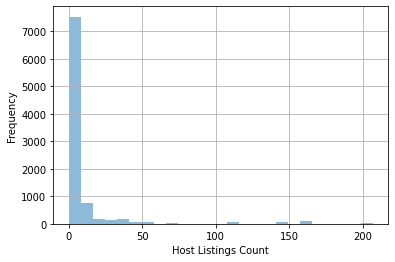

In [18]:
dataframe_train['Host Listings Count'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Host Listings Count')
dataframe_train_2 = dataframe_train[dataframe_train['Host Listings Count'] < 210] # Quitamos outliers

Text(0.5, 0, 'Latitude')

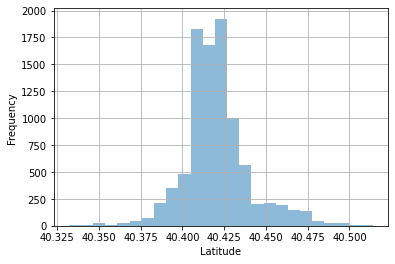

In [19]:
dataframe_train_2['Latitude'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Latitude')

Text(0.5, 0, 'Longitude')

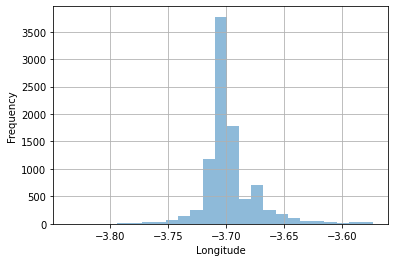

In [20]:
dataframe_train_2['Longitude'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Longitude')

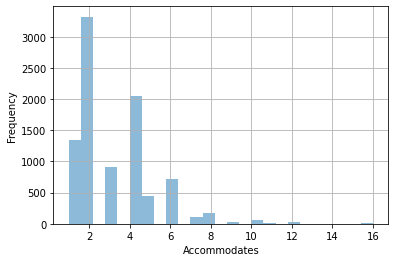

In [21]:
dataframe_train_2['Accommodates'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Accommodates')
dataframe_train_2['Accommodates'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Accommodates'] < 13] # Quitamos outliers


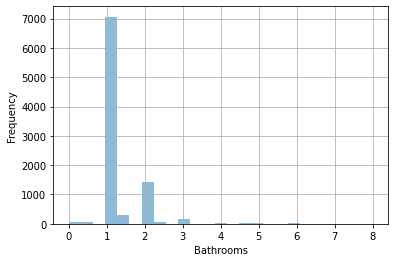

In [22]:
dataframe_train_2['Bathrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Bathrooms')
dataframe_train_2['Bathrooms'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Bathrooms'] < 6.1] # Quitamos outliers

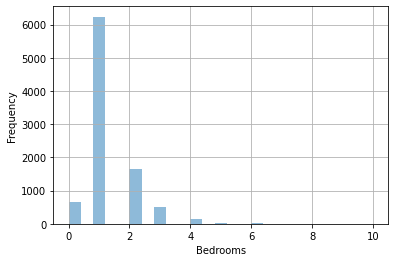

In [23]:
dataframe_train_2['Bedrooms'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Bedrooms')
dataframe_train_2['Bedrooms'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Bedrooms'] < 6.1] # Quitamos outliers


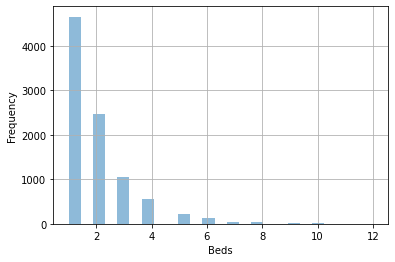

In [24]:
dataframe_train_2['Beds'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Beds')
dataframe_train_2['Beds'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Beds'] < 11] # Quitamos outliers


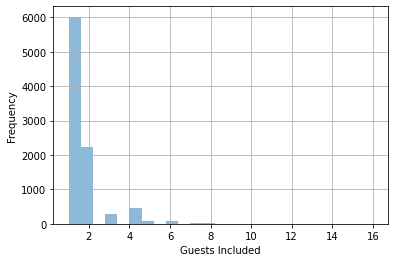

In [25]:
dataframe_train_2['Guests Included'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Guests Included')
dataframe_train_2['Guests Included'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Guests Included'] < 10] # Quitamos outliers


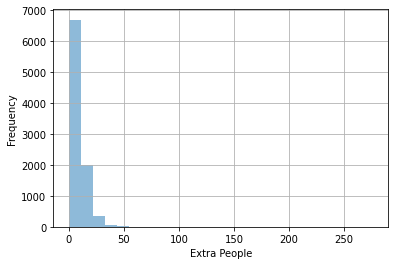

In [26]:
dataframe_train_2['Extra People'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Extra People')
dataframe_train_2['Extra People'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Extra People'] < 50] # Quitamos outliers


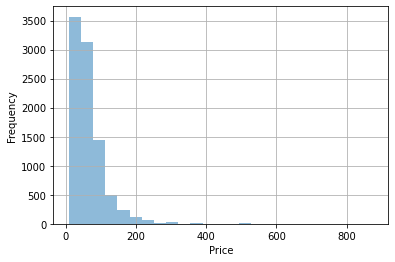

In [27]:
dataframe_train_2['Price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('Price')
dataframe_train_2['Price'].value_counts()
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Price'] < 400] # Quitamos outliers


Scatter plot de la variable objetivo definida y como variable dependiente y algunas de las variables explicativas como independientes, en el caso de algunas de las codificadas usaremos waterfront

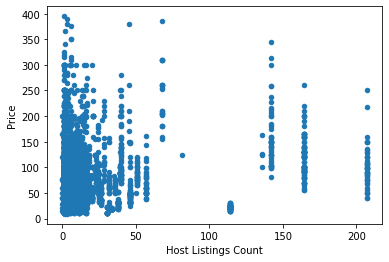

In [28]:
dataframe_train_2.plot(kind = 'scatter',x='Host Listings Count',y = 'Price')


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


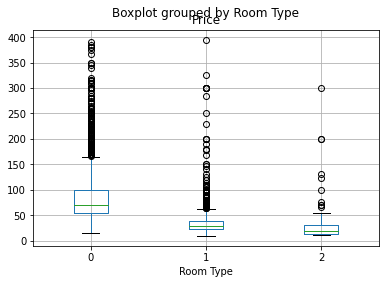

In [29]:
dataframe_train_2.boxplot(by='Room Type',column = 'Price')


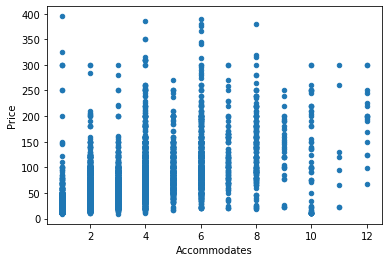

In [30]:
dataframe_train_2.plot(kind = 'scatter',x='Accommodates',y = 'Price')


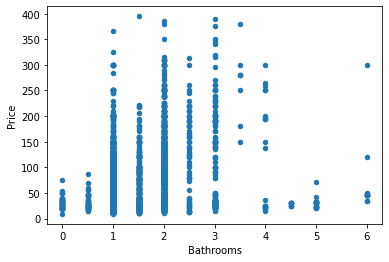

In [31]:
dataframe_train_2.plot(kind = 'scatter',x='Bathrooms',y = 'Price')


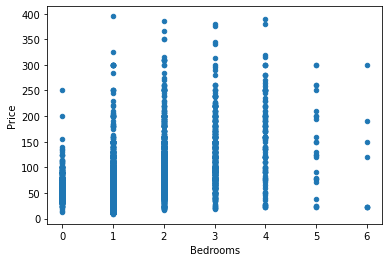

In [32]:
dataframe_train_2.plot(kind = 'scatter',x='Bedrooms',y = 'Price')


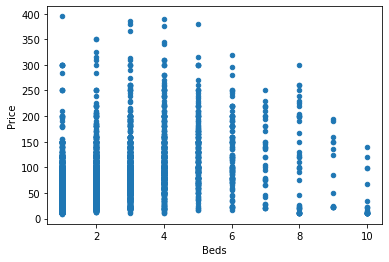

In [33]:
dataframe_train_2.plot(kind = 'scatter',x='Beds',y = 'Price')


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


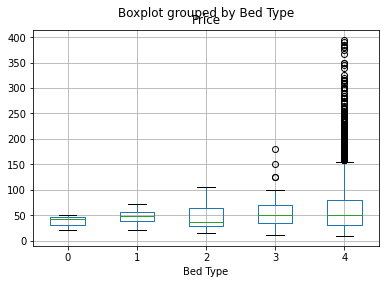

In [34]:
dataframe_train_2.boxplot(by='Bed Type',column = 'Price')


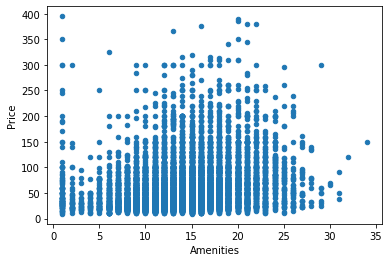

In [35]:
dataframe_train_2.plot(kind = 'scatter',x='Amenities',y = 'Price')


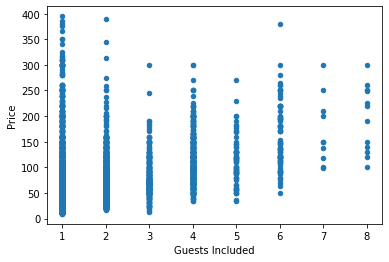

In [36]:
dataframe_train_2.plot(kind = 'scatter',x='Guests Included',y = 'Price')


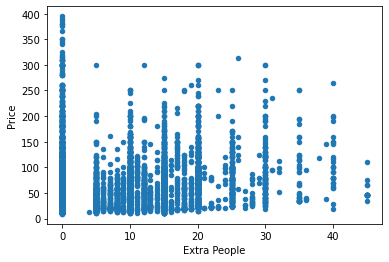

In [37]:
dataframe_train_2.plot(kind = 'scatter',x='Extra People',y = 'Price')


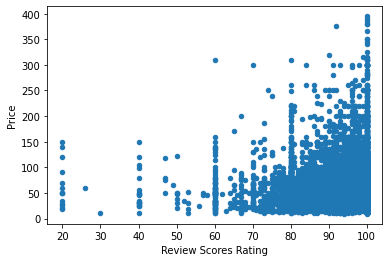

In [38]:
dataframe_train_2.plot(kind = 'scatter',x='Review Scores Rating',y = 'Price')


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


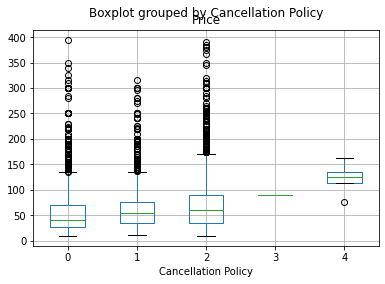

In [39]:
dataframe_train_2.boxplot(by='Cancellation Policy',column = 'Price')


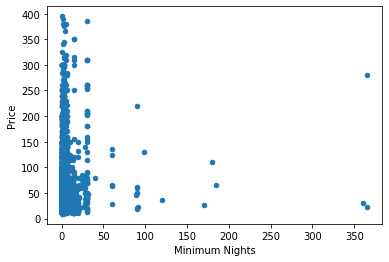

In [40]:
dataframe_train_2.plot(kind = 'scatter',x='Minimum Nights',y = 'Price')


In [41]:
dataframe_train_2['Minimum Nights'].value_counts()

2      3228
1      3137
3      1476
4       375
5       288
7       238
10      109
6        66
30       52
15       50
14       23
20       20
28        8
90        7
12        6
9         5
60        5
21        5
8         5
25        3
13        3
26        3
365       2
17        1
19        1
99        1
120       1
89        1
29        1
11        1
40        1
32        1
180       1
170       1
185       1
360       1
91        1
Name: Minimum Nights, dtype: int64

In [42]:
dataframe_train_2 = dataframe_train_2[dataframe_train_2['Minimum Nights'] < 50] # Quitamos outliers


In [43]:
print(f'Porcentaje de registros eliminados: {((dataframe_train.shape[0] - dataframe_train_2.shape[0])/dataframe_train.shape[0])*100}%')


Porcentaje de registros eliminados: 1.49286023366508%


Vamos a ver si hay colinealidad 

In [44]:
dataframe_train_2.corr(method='pearson')

,Host Listings Count,Neighbourhood,Zipcode,Latitude,Longitude,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed Type,Amenities,Price,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Reviews per Month
Host Listings Count,1.000000,-0.008636,-0.008212,0.007400,-0.041158,-0.085800,-0.107556,0.138281,0.177054,0.074070,0.092382,0.007295,-0.024253,0.205506,0.303479,0.066484,0.040091,0.118287,0.004113,-0.093307,-0.072961,-0.046774,-0.020013,-0.140831,-0.129207,0.020630,-0.063852,0.249498,-0.118957
Neighbourhood,-0.008636,1.000000,-0.012381,-0.081705,0.093888,-0.013453,-0.006879,0.012855,0.033900,0.014306,-0.016561,0.000549,-0.001147,0.045063,0.008012,0.023359,-0.005476,-0.023055,0.013461,0.001774,0.015093,0.015698,0.006849,0.001714,0.005114,0.066122,0.012084,0.035348,0.037495
Zipcode,-0.008212,-0.012381,1.000000,0.023447,0.046897,0.017147,0.019961,-0.025924,-0.000274,-0.021171,-0.017598,-0.000335,-0.001431,-0.017441,-0.024371,-0.014125,-0.010097,0.000754,-0.000327,-0.013588,-0.004092,0.000862,-0.003120,-0.001668,0.000733,-0.022757,-0.001528,-0.014018,-0.016071
Latitude,0.007400,-0.081705,0.023447,1.000000,0.253475,0.041665,-0.025792,-0.000321,0.033180,0.021873,0.007224,0.008957,0.046059,0.069578,0.049876,-0.014561,0.012547,0.020497,0.004639,-0.063033,0.003217,0.008752,-0.000627,0.012237,0.014570,0.052491,0.001609,-0.025135,-0.063537
Longitude,-0.041158,0.093888,0.046897,0.253475,1.000000,0.072831,0.076865,-0.065462,0.007276,0.002823,-0.040184,-0.006341,0.027299,-0.038126,-0.051308,-0.040613,-0.023543,-0.002233,-0.003580,-0.043928,0.033370,0.031207,0.031767,0.023576,0.018587,-0.066793,0.035301,-0.071666,-0.007901
Property Type,-0.085800,-0.013453,0.017147,0.041665,0.072831,1.000000,0.114191,-0.051758,0.025676,0.015947,-0.008132,0.011573,0.022371,-0.046445,-0.063984,-0.028946,-0.014391,-0.030550,-0.000210,-0.053525,0.010431,0.002423,-0.001236,0.001997,-0.009138,-0.032567,0.000862,-0.069277,-0.028369
Room Type,-0.107556,-0.006879,0.019961,-0.025792,0.076865,0.114191,1.000000,-0.524280,0.019476,-0.247390,-0.286010,0.003393,-0.220667,-0.544529,-0.410391,-0.380697,-0.129181,-0.075574,-0.009671,-0.149471,0.058148,0.009271,-0.000828,0.020218,0.001656,-0.052468,0.057389,-0.200414,-0.123094
Accommodates,0.138281,0.012855,-0.025924,-0.000321,-0.065462,-0.051758,-0.524280,1.000000,0.271950,0.673526,0.805833,0.034550,0.210277,0.606551,0.384981,0.588982,0.350451,-0.020384,0.002095,0.096720,-0.100604,-0.084034,-0.054879,-0.089487,-0.069666,0.003591,-0.095610,0.215969,0.075027
Bathrooms,0.177054,0.033900,-0.000274,0.033180,0.007276,0.025676,0.019476,0.271950,1.000000,0.371109,0.292367,0.040025,0.129930,0.293022,0.191465,0.154969,0.088352,0.100703,-0.003988,-0.062020,0.038066,0.037241,0.019689,-0.012916,-0.008099,0.057123,0.030464,0.116680,-0.062655
Bedrooms,0.074070,0.014306,-0.021171,0.021873,0.002823,0.015947,-0.247390,0.673526,0.371109,1.000000,0.662879,0.064935,0.153216,0.508869,0.317455,0.438546,0.181464,0.040983,0.000896,-0.023561,-0.005069,0.001112,-0.003905,-0.019770,-0.005489,-0.002763,-0.011895,0.072944,-0.032309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


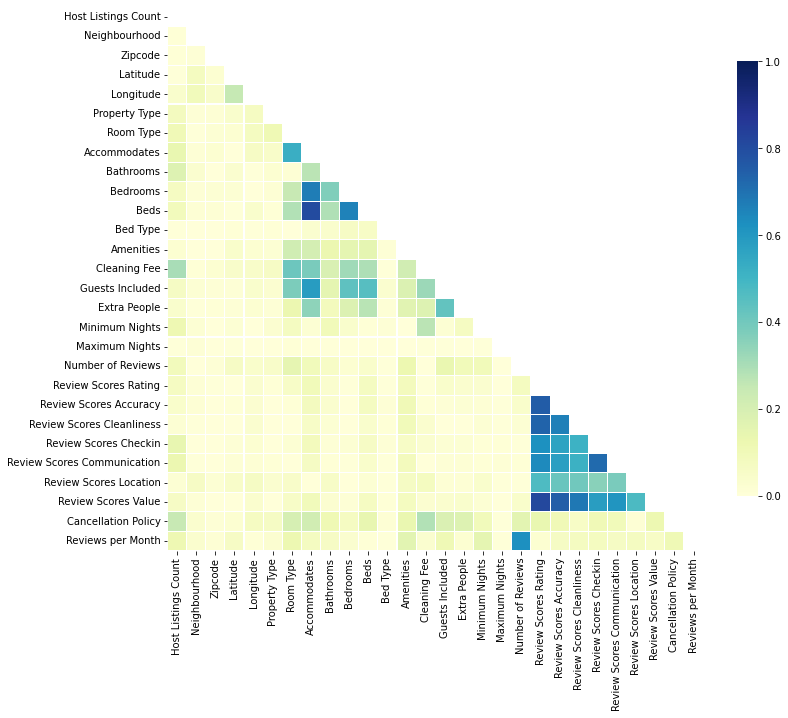

In [45]:
corr = np.abs(dataframe_train_2.drop(['Price'], axis=1).corr())
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

Alta colinealidad entre beds y accommodates, eliminamos accommodates, vemos que hay relación entre las review scores, en concreto:

Review Scores Rating = (Review Scores Accuracy + Review Scores Cleanliness + Review Scores Checkin + Review Scores Communication + Review Scores Location + Review Scores Value)*100/60.

Nos quedaremos con Review Scores Rating que es la combinación de las demás

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a4a645450>,
      dtype=object)

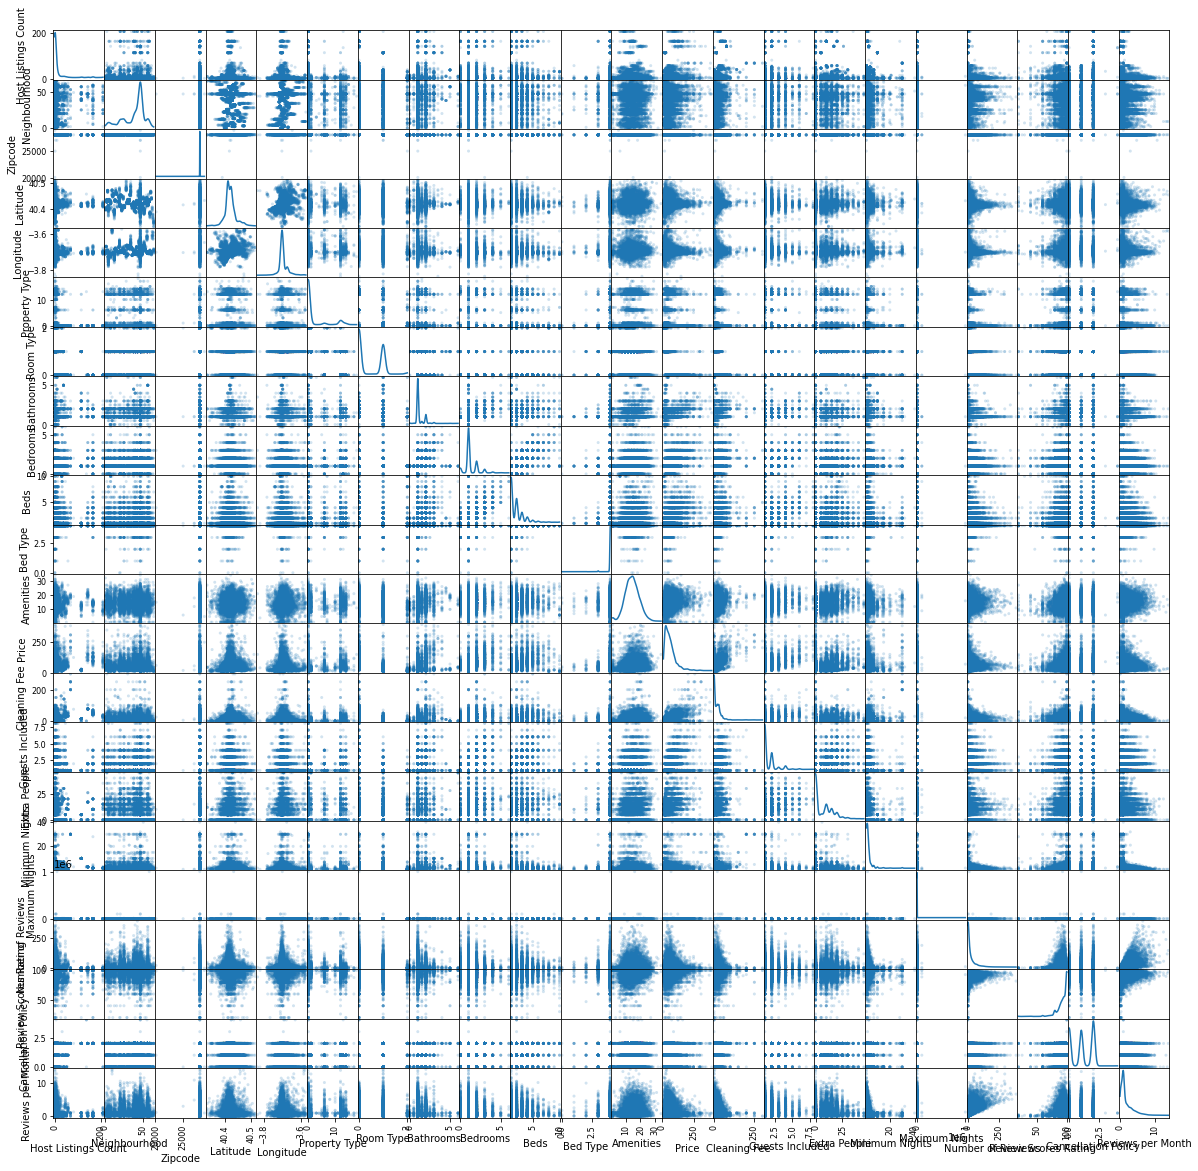

In [46]:
dataframe_train_final = dataframe_train_2.drop(['Accommodates', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value'], axis=1)
pd.plotting.scatter_matrix(dataframe_train_final, alpha=0.2, figsize=(20, 20), diagonal = 'kde')


Vamos a ver la relación con la variable dependiente, dividimos en variable dependiente e independientes


Text(0.5, 1.0, 'Mutual information score')

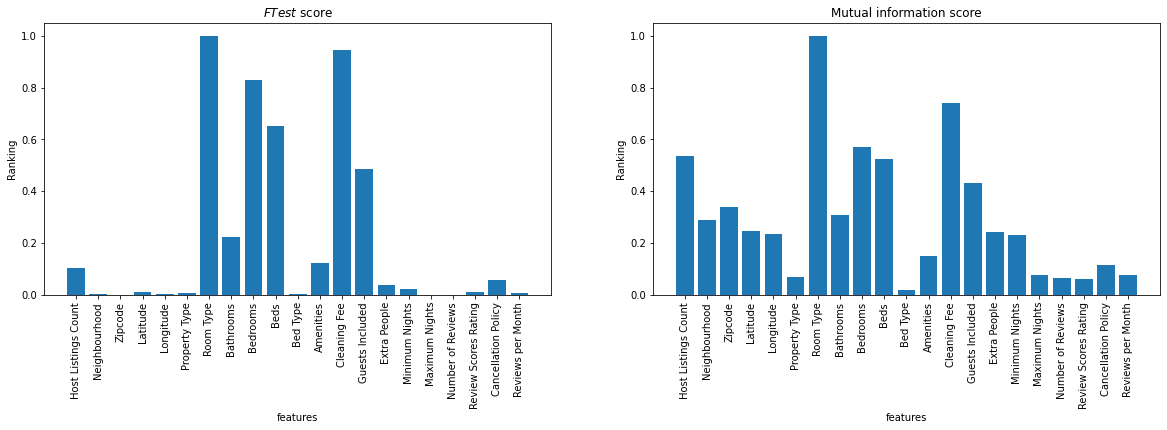

In [47]:
Y_train = dataframe_train_final['Price']
X_train = dataframe_train_final.drop(['Price'], axis=1)

feature_names = X_train.columns
f_test, _ = f_regression(X_train, Y_train)
f_test /= np.max(f_test)
mi = mutual_info_regression(X_train, Y_train)
mi /= np.max(mi)

plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
plt.bar(range(X_train.shape[1]),f_test,  align="center")
plt.xticks(range(X_train.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$FTest$ score')

plt.subplot(1,2,2)
plt.bar(range(X_train.shape[1]),mi, align="center")
plt.xticks(range(X_train.shape[1]),feature_names, rotation = 90)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

Con estos resultados vamos a eliminar un par de variables más debido a su puntuación baja en el Ftest y mutual information score.

In [48]:
X_train = X_train.drop(['Property Type', 'Bed Type', 'Maximum Nights'], axis=1)


Preparamos para modelado, para ello vamos a realizar en el test los fillna y codificaciones que hicimos en el train


In [49]:
dataframe_test['Price'].fillna(dataframe_test['Price'].mode()[0], inplace=True)
dataframe_test = dataframe_test[dataframe_test['Price'] < 400]

dataframe_test = dataframe_test.drop(['Square Feet', 'Security Deposit', 'Property Type', 'Bed Type', 'Maximum Nights', 'Accommodates', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value'], axis=1)

dataframe_test['Host Listings Count'].fillna(dataframe_test['Host Listings Count'].mode()[0], inplace=True)
dataframe_test = dataframe_test[dataframe_test['Host Listings Count'] < 210]

dataframe_test['Neighbourhood'].fillna('Other', inplace=True)
dataframe_test['Neighbourhood'] = le1.transform(dataframe_test['Neighbourhood'])

dataframe_test['Zipcode'].fillna(dataframe_test['Zipcode'].mode()[0], inplace=True)
dataframe_test['Zipcode'] = dataframe_test['Zipcode'].astype(int)

dataframe_test['Room Type'] = le3.transform(dataframe_test['Room Type'])

dataframe_test['Bathrooms'].fillna(dataframe_test['Bathrooms'].mode()[0], inplace=True)
dataframe_test = dataframe_test[dataframe_test['Bathrooms'] < 6.1]

dataframe_test['Bedrooms'].fillna(dataframe_test['Bedrooms'].mode()[0], inplace=True)
dataframe_test = dataframe_test[dataframe_test['Bedrooms'] < 6.1]

dataframe_test['Beds'].fillna(dataframe_test['Beds'].mode()[0], inplace=True)
dataframe_test = dataframe_test[dataframe_test['Beds'] < 11]

dataframe_test['Amenities'].fillna('', inplace=True)
dataframe_test['Amenities'] = dataframe_test['Amenities'].apply(lambda x: len(x.split(',')))

dataframe_test['Cleaning Fee'].fillna(0, inplace=True) 

dataframe_test = dataframe_test[dataframe_test['Guests Included'] < 10]

dataframe_test = dataframe_test[dataframe_test['Extra People'] < 50]

dataframe_test = dataframe_test[dataframe_test['Minimum Nights'] < 50]

dataframe_test['Review Scores Rating'].fillna(dataframe_test['Review Scores Rating'].mode()[0], inplace=True)

dataframe_test['Cancellation Policy'] = le5.transform(dataframe_test['Cancellation Policy'])

dataframe_test['Reviews per Month'].fillna(dataframe_test['Reviews per Month'].mode()[0], inplace=True)


Buscamos el precio maximo del dataframe para escalar los precios en el rango 0-1 y dividimos en variable dependiente e independientes


In [50]:
maxPrice = dataframe_train_final["Price"].max()
Y_train  = dataframe_train_final["Price"] / maxPrice
X_train = dataframe_train_final.drop(['Price'],  axis=1)
Y_test = dataframe_test["Price"] / maxPrice
X_test = dataframe_test.drop(['Price'],  axis=1)

Transformamos los datos mediante un escalado min-max

In [51]:
continuous = ["Zipcode","Neighbourhood","Room Type", "Bathrooms", "Bedrooms","Beds","Amenities","Cleaning Fee","Guests Included","Extra People","Minimum Nights","Number of Reviews","Review Scores Rating","Cancellation Policy","Reviews per Month"]
# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
X_train = cs.fit_transform(X_train[continuous])
X_test = cs.transform(X_test[continuous])

Creamos el modelo de red reuronal con 2, se ha utilizado una función de tipo relu y para la salida una lineal. 

La función de pérdidas se ha denominado mean_absolute_percentage_error utilizando el optimizador opt.

In [52]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="linear"))

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Entrenamos el modelo

In [53]:
print("Entrenando el modelo...")
model.fit(x=X_train, y=Y_train, 
validation_data=(X_train, Y_train),
epochs=50, batch_size=8)

Entrenando el modelo...
Epoch 1/50
1139/1139 [==============================] - 5s 3ms/step - loss: 34.7670 - val_loss: 27.6767
Epoch 2/50
1139/1139 [==============================] - 3s 3ms/step - loss: 29.4085 - val_loss: 26.8829
Epoch 3/50
1139/1139 [==============================] - 3s 3ms/step - loss: 28.3165 - val_loss: 29.4579
Epoch 4/50
1139/1139 [==============================] - 3s 3ms/step - loss: 27.5806 - val_loss: 26.5178
Epoch 5/50
1139/1139 [==============================] - 3s 3ms/step - loss: 26.9587 - val_loss: 26.6388
Epoch 6/50
1139/1139 [==============================] - 4s 3ms/step - loss: 26.8255 - val_loss: 26.1713
Epoch 7/50
1139/1139 [==============================] - 3s 3ms/step - loss: 26.4503 - val_loss: 26.7859
Epoch 8/50
1139/1139 [==============================] - 3s 3ms/step - loss: 26.3041 - val_loss: 25.7850
Epoch 9/50
1139/1139 [==============================] - 3s 3ms/step - loss: 26.2224 - val_loss: 25.4865
Epoch 10/50
1139/1139 [=================

Evaluamos el modelo con las muestras test

In [54]:
preds_test = model.predict(X_test)
preds_train = model.predict(X_train)
print("Training MSE:", round(mean_squared_error(Y_train, preds_train),4))
print("Validation MSE:", round(mean_squared_error(Y_test, preds_test),4))
print("\nTraining r2:", round(r2_score(Y_train, preds_train),4))
print("Validation r2:", round(r2_score(Y_test, preds_test),4))

print("\nPrediciendo el precio...")
diff = preds_test.flatten() - Y_test
percentDiff = (diff / Y_test) * 100
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("Precio de casas: {}, std precio casas: {}€".format(dataframe["Price"].mean(),dataframe["Price"].std()))
print(" media: {:.2f}%, std: {:.2f}%".format(mean, std))


Training MSE: 0.0044
Validation MSE: 0.0051

Training r2: 0.6608
Validation r2: 0.6267

Prediciendo el precio...
Precio de casas: 65.92468555841795, std precio casas: 56.00855184369228€
 media: 28.17%, std: 28.32%


Ambos resultados son similares en train y test, por lo que no sufrimos overfitting.

Vamos a realizar un modelo más con más capas y regularización L1.

In [60]:
model2 = Sequential()
model2.add(Dense(128, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1(0.005), activation="relu"))
model2.add(Dense(64, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l1(0.005), activation="relu"))
model2.add(Dense(32, kernel_regularizer=regularizers.l1(0.005), activation="relu"))
model2.add(Dense(1, kernel_regularizer=regularizers.l1(0.005), activation="linear"))

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model2.compile(loss="mean_absolute_percentage_error", optimizer='adam', metrics=['mean_squared_error'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Entrenamos el modelo

In [61]:
print("Entrenando el modelo...")
model2.fit(x=X_train, y=Y_train, 
validation_data=(X_train, Y_train),
epochs=50, batch_size=8)

Entrenando el modelo...
Epoch 1/50
1139/1139 [==============================] - 5s 4ms/step - loss: 36.1041 - mean_squared_error: 0.0080 - val_loss: 33.3306 - val_mean_squared_error: 0.0070
Epoch 2/50
1139/1139 [==============================] - 4s 3ms/step - loss: 31.5401 - mean_squared_error: 0.0065 - val_loss: 30.7342 - val_mean_squared_error: 0.0073
Epoch 3/50
1139/1139 [==============================] - 4s 3ms/step - loss: 30.3093 - mean_squared_error: 0.0062 - val_loss: 29.7598 - val_mean_squared_error: 0.0055
Epoch 4/50
1139/1139 [==============================] - 4s 3ms/step - loss: 29.4197 - mean_squared_error: 0.0060 - val_loss: 28.9537 - val_mean_squared_error: 0.0063
Epoch 5/50
1139/1139 [==============================] - 4s 3ms/step - loss: 28.9336 - mean_squared_error: 0.0058 - val_loss: 27.6283 - val_mean_squared_error: 0.0058
Epoch 6/50
1139/1139 [==============================] - 4s 3ms/step - loss: 28.4737 - mean_squared_error: 0.0060 - val_loss: 27.8525 - val_mean_sq

Evaluamos el modelo con las muestras test

In [62]:
preds_test = model2.predict(X_test)
preds_train = model2.predict(X_train)
print("Training MSE:", round(mean_squared_error(Y_train, preds_train),4))
print("Validation MSE:", round(mean_squared_error(Y_test, preds_test),4))
print("\nTraining r2:", round(r2_score(Y_train, preds_train),4))
print("Validation r2:", round(r2_score(Y_test, preds_test),4))

print("\nPrediciendo el precio...")
diff = preds_test.flatten() - Y_test
percentDiff = (diff / Y_test) * 100
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("Precio de casas: {}, std precio casas: {}€".format(dataframe["Price"].mean(),dataframe["Price"].std()))
print(" media: {:.2f}%, std: {:.2f}%".format(mean, std))

Training MSE: 0.0051
Validation MSE: 0.0056

Training r2: 0.6071
Validation r2: 0.5899

Prediciendo el precio...
Precio de casas: 65.92468555841795, std precio casas: 56.00855184369228€
 media: 25.52%, std: 23.22%


Nuestro modelo ha empeorado, por lo que el primero daría mejores resultados al tener un R^2 mayor para train y test.

**CNN**

Cargamos las imagenes

In [64]:
dataframe=pd.concat([dataframe_train_final,dataframe_test])
dataframe = dataframe.drop(['Host Listings Count','Latitude','Longitude','Property Type','Bed Type','Maximum Nights'], axis=1)
images = []

for i in dataframe.index:
    image = cv2.imread("drive/MyDrive/images/image{}.jpg".format(str(i)))
    image = cv2.resize(image, (64, 64))
    images.append(image)
    
    
images = np.array(images)
images = images / 255.0

(X_train_att_photo, X_test_att_photo, X_train_img_photo, X_test_img_photo) = train_test_split(dataframe, images, test_size=0.3001, shuffle = False, random_state = 0)


Buscamos el precio maximo del dataframe para escalar los precios en el rango 0-1 y dividimos en variable dependiente e independientes


In [65]:
maxPrice = X_train_att_photo["Price"].max()
Y_train_photos = X_train_att_photo["Price"] / maxPrice
X_train_att_photo = X_train_att_photo.drop(['Price'],  axis=1)
Y_test_photos = X_test_att_photo["Price"] / maxPrice
X_test_att_photo = X_test_att_photo.drop(['Price'],  axis=1)

Definimos la entrada del modelo con sus capas convolucionales

In [66]:
inputs = Input(shape=(64, 64, 3))

for (i, f) in enumerate((16, 32, 64)):
	if i == 0:
		x = inputs
	x = Conv2D(f, (3, 3), padding="same")(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=-1)(x)
	x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization(axis=-1)(x)
x = Dropout(0.5)(x)
x = Dense(4)(x)
x = Activation("relu")(x)
x = Dense(1, activation="linear")(x)

Construimos el modelo

In [67]:
model_photos = Model(inputs, x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_photos.compile(loss="mean_absolute_percentage_error", optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Entrenamos el modelo

In [68]:
print("Entrenando el modelo...")
model_photos.fit(x=X_train_img_photo, y=Y_train_photos, 
    validation_data=(X_test_img_photo, Y_test_photos),
    epochs=20, batch_size=8)

Entrenando el modelo...
Epoch 1/20
1139/1139 [==============================] - 71s 61ms/step - loss: 224.6638 - val_loss: 47.7134
Epoch 2/20
1139/1139 [==============================] - 67s 59ms/step - loss: 50.5798 - val_loss: 46.2987
Epoch 3/20
1139/1139 [==============================] - 68s 60ms/step - loss: 47.1411 - val_loss: 45.5843
Epoch 4/20
1139/1139 [==============================] - 71s 63ms/step - loss: 46.3055 - val_loss: 45.2016
Epoch 5/20
1139/1139 [==============================] - 68s 59ms/step - loss: 46.1597 - val_loss: 44.7850
Epoch 6/20
1139/1139 [==============================] - 67s 59ms/step - loss: 45.6784 - val_loss: 44.5026
Epoch 7/20
1139/1139 [==============================] - 66s 58ms/step - loss: 45.5697 - val_loss: 52.0918
Epoch 8/20
1139/1139 [==============================] - 67s 59ms/step - loss: 45.6518 - val_loss: 45.5364
Epoch 9/20
1139/1139 [==============================] - 67s 59ms/step - loss: 45.6022 - val_loss: 44.7483
Epoch 10/20
1139/1139

Evaluamos el modelo con las muestras test

In [71]:
preds_test = model_photos.predict(X_test_img_photo)
preds_train = model_photos.predict(X_train_img_photo)
print("Training MSE:", round(mean_squared_error(Y_train_photos, preds_train),4))
print("Validation MSE:", round(mean_squared_error(Y_test_photos, preds_test),4))
print("\nTraining r2:", round(r2_score(Y_train_photos, preds_train),4))
print("Validation r2:", round(r2_score(Y_test_photos, preds_test),4))

print("\nPrediciendo el precio...")
diff = preds_test.flatten() - Y_test_photos
percentDiff = (diff / Y_test_photos) * 100
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("Precio de casas: {}, std precio casas: {}€".format(dataframe["Price"].mean(),dataframe["Price"].std()))
print(" media: {:.2f}%, std: {:.2f}%".format(mean, std))


Training MSE: 0.0194
Validation MSE: 0.0311

Training r2: -0.4847
Validation r2: -1.2819

Prediciendo el precio...
Precio de casas: 63.367919452770735, std precio casas: 45.44800964903925€
 media: 47.19%, std: 115.31%


R2 es una magnitud positiva por lo que al dar negativa se interpreta como 0, es decir este modelo nos ha dado un resultado muy malo. 

Este hecho se puede deber a que las fotos no siguen ningun patron establecido y encontramos fotos de diversas estancias, perspectivas, vistas... Este hecho junto a que la libreria Conv2D no está especializada en el estudio de estancias provoca que el modelo no sea un buen predictor.

De este modo podemos confirmar que con estos datos un modelo de red neuronal que trata los valores cuantitativos es claramente mejor que uno de CNN.

Combinamos las salidas de ambos modelos para definir un modelo que sea capaz de aceptar como entrada datos numércios y categóricos.

In [72]:
combinedInput = concatenate([model.output, model_photos.output])


Creamos las layers

In [73]:
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)

Creamos el modelo final con la entrada de ambos modelos vistos anteriormente

In [74]:
model_final = Model(inputs=[model.input, model_photos.input], outputs=x)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model_final.compile(loss="mean_absolute_percentage_error", optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Entrenamos el modelo

In [76]:
print("Entrenando el modelo...")
model_final.fit(
	x=[X_train_att_photo, X_train_img_photo], y=Y_train,
	validation_data=([X_test_att_photo, X_test_img_photo], Y_test),
	epochs=20, batch_size=8)

Entrenando el modelo...
Epoch 1/20
1139/1139 [==============================] - 119s 105ms/step - loss: 71.6987 - val_loss: 46.8910
Epoch 2/20
1139/1139 [==============================] - 76s 67ms/step - loss: 68.9191 - val_loss: 50.0657
Epoch 3/20
1139/1139 [==============================] - 77s 68ms/step - loss: 48.5790 - val_loss: 47.5297
Epoch 4/20
1139/1139 [==============================] - 78s 69ms/step - loss: 44.1052 - val_loss: 44.4436
Epoch 5/20
1139/1139 [==============================] - 78s 68ms/step - loss: 50.0684 - val_loss: 46.7940
Epoch 6/20
1139/1139 [==============================] - 77s 68ms/step - loss: 45.0332 - val_loss: 90.3552
Epoch 7/20
1139/1139 [==============================] - 79s 69ms/step - loss: 43.8154 - val_loss: 62.4472
Epoch 8/20
1139/1139 [==============================] - 79s 69ms/step - loss: 43.8455 - val_loss: 45.1550
Epoch 9/20
1139/1139 [==============================] - 78s 69ms/step - loss: 43.7382 - val_loss: 44.6023
Epoch 10/20
1139/113

Evaluamos el modelo con las muestras test

In [81]:
preds_test = model_final.predict([X_test_att_photo, X_test_img_photo])
preds_train = model_final.predict([X_train_att_photo, X_train_img_photo])
print("Training MSE:", round(mean_squared_error(Y_train_photos, preds_train),4))
print("Validation MSE:", round(mean_squared_error(Y_test_photos, preds_test),4))
print("\nTraining r2:", round(r2_score(Y_train_photos, preds_train),4))
print("Validation r2:", round(r2_score(Y_test_photos, preds_test),4))


print("Prediciendo precios...")
diff = preds_test.flatten() - Y_test_photos
percentDiff = (diff / Y_test_photos) * 100
absPercentDiff = np.abs(percentDiff)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
print("Precio de casas: {}, std precio casas: {}€".format(dataframe["Price"].mean(),dataframe["Price"].std()))
print(" media: {:.2f}%, std: {:.2f}%".format(mean, std))

Training MSE: 0.015
Validation MSE: 0.0165

Training r2: -0.1504
Validation r2: -0.2138
Prediciendo precios...
Precio de casas: 63.367919452770735, std precio casas: 45.44800964903925€
 media: 45.23%, std: 34.24%


Al juntar los datos cuantitativos y las imágenes y realizar un modelo se puede observar que sucede como con el modelo de las imágenes solo, las r^2 dan negativas y por lo tanto se interpretarían como 0. 

De este modo por la misma razón que en el caso anterior, a pesar de que la lógica nos lleva que al añadir más datos de entrada al modelo este debería de mejorar, este empeorá. Siendo finalmente el mejor modelo predictor el primero de todos los realizados.
